*Luis Antonio Ortega Andrés     
Antonio Coín Castro*

# Algoritmo de Eliminación de Variables

In [1]:
import numpy as np

## Análisis teórico

Este algoritmo se utiliza para hacer inferencia en redes. Supongamos que tenemos la factorización de una distribución conjunta 

$$ P(\mathbf{X}) = P(X_1, X_2, \dots, X_N) = \prod_{i=1}^N P(X_i|Par(X_i))$$ 

y una evidenica $ \mathbf{Z}=\mathbf{z} $, donde $\mathbf{Z} \subset \mathbf{X}$ es un subconjunto de las variables del problema y $\mathbf{z}$ son sus valores observados. El objetivo es obtener la distribución de parte de las variables del problema, $\mathbf{W} \subset \mathbf{X}$, dada la evidencia $\mathbf{Z}=\mathbf{z}$. Es decir, queremos obtener $P(\mathbf{W}|\mathbf{Z}=\mathbf{z})$:

$$ P(\mathbf{W}|\mathbf{Z}=\mathbf{z}) = \sum_{X \setminus (W\cup Z)} \frac{P(\mathbf{X}\setminus \mathbf{Z},\mathbf{Z}=\mathbf{z})}{P(\mathbf{Z}=\mathbf{z})} \propto \sum_{X \setminus (W\cup Z)} P(\mathbf{X}\setminus \mathbf{Z},\mathbf{Z}=\mathbf{z}).$$

Para ello debemos:

* Reducir los factores que incluyan $\mathbf{Z}$.
* Eliminar el resto de variables no incluidas $\mathbf{W}$.


Algoritmo de eliminación de variables esquemático para un conjunto de factores $\mathbf{\Phi}=\{\Phi_1,\dots,\Phi_N\}$:
1.  Reducir todos los factores que contengan alguna variable de $\mathbf{Z}$ en su dominio, usando la evidencia dada $\mathbf{Z}=\mathbf{z}$.
2.  Para cada variable X en $\mathbf{X} \setminus (\mathbf{W} \cup \mathbf{Z})$, eliminar la variable X mediante marginalización:
    1. Hacer el producto de todos los factores que tienen X en su dominio: $\psi = \prod_{i \mid X\in Dom(\Phi_i) }\Phi_i$. 
    2. Marginalizar X del factor producto obtenido en A: $\tau = \sum_X \psi$.
    3. Actualizar la lista de factores quitando los factores que incluyen X y añadiendo el factor marginalizado $\tau$: $\mathbf{\Phi} = (\mathbf{\Phi} \setminus {\psi}) \cup \tau$.
3. Multiplicar factores restantes.
4. Renormalizar para obtener una distribución.

## Implementación

Definimos una clase para representar una red bayesiana a partir de la factorización de la distribución conjunta. Nos ayudamos de una serie de funciones auxiliares para normalizar, marginalizar y reducir factores, e implementamos un método para aplicar el algoritmo de eliminación de variables.

In [2]:
class BayesianNetwork:
    """
    Represents a Bayesian Network via its joint distribution decomposition.
    """
    
    def __init__(self, factor_list):
        """ Construct a network from its factorization. Every factor must have the same
            number of dimensions, which coincides with the total number of variables."""
        
        self.factor_list = factor_list
        self.variables = np.arange(len(self.factor_list))

    def _normalize(self, distribution):
        """ Normalize a distribution so that all values add up to 1. """

        return distribution / np.sum(distribution)

    def _marginal(self, distribution, variables):
        """ Marginalize a distribution for the given list of (indices of) variables. """

        return np.sum(distribution, axis = tuple(variables), keepdims = True)

    def _reduce(self, distribution, variables, asignments, normalize_output = True):
        """ This function receives a distribution, 
            a list of indices to variables and 
            a list of assignments to those variables.
            
            It performs reduction on the specified variables with the given assignments. """

        reduced = distribution.copy()
        for variable, asignment in zip(variables, asignments):
            reduced = np.swapaxes(reduced, 0, variable)[[asignment]]
            reduced = np.swapaxes(reduced, 0, variable)

        return self._normalize(reduced) if normalize_output else reduced
    
    def _factor_has_var(self, factor, variable):
        """ Return whether a given factor has a specific variable on its domain. """

        return factor.shape[variable] > 1

    def _multi_prod(self, arrays):
        """ Perform the element-wise product of multiple arrays. """
        
        assert(len(arrays) > 0)

        res = arrays[0]
        for arr in arrays[1:]:
            res = res * arr

        return res

    def VE(self, W, Zs = [], zs = [], order = []):
        """ Implement the variable elimination algorithm.

            Input:
                * W:       list of desired variables in the output factor.
                * Zs:      list with the observed variables.
                * zs:      list with the values of the observed variables.
                * order:   order in which the variables not in (W U Zs) are processed. 
                           If empty, an ascending order is assumed. If not empty, the indices
                           must be relative to the ones in self.factor_list.
            
            Ouput:
                * Factor representing the joint distribution P(W|Zs=zs).
                * The size of the biggest factor processed.
        """
        
        factors = self.factor_list.copy()
        variables_factors = np.arange(len(factors))

        # -- STEP 1: reduce factors that contain any variable in Zs --
        for Z, z in zip(Zs, zs):
            for i, factor in enumerate(factors):
                if self._factor_has_var(factor, Z):
                    factors[i] = self._reduce(factor, [Z], [z], False)

        # -- STEP 2: eliminate variables via marginalization --
        variables_rest = np.setdiff1d(variables_factors, np.union1d(W, Zs))
        
        # Take the desired ordering into account
        if len(order) > 0:
            assert((np.unique(order) == np.unique(variables_rest)).all() 
                      and len(order) == len(variables_rest))
            variables_rest = order
            
        # Process each variable in order
        max_size = 0
        for X in variables_rest:
            # Recover the indices of factors that have X on their domain
            factors_X_idx = [i for i in variables_factors if self._factor_has_var(factors[i], X)]
            
            # Multiply those factors together
            psi = self._multi_prod([factors[i] for i in factors_X_idx])
            
            # Marginalize the product with respect to X
            tau = self._marginal(psi, [X])
            
            # Update the factor list
            factors = [factors[i] for i in np.setdiff1d(variables_factors, factors_X_idx)] + [tau]
            variables_factors = np.arange(len(factors))
            
            # Compute size of the processed factor
            max_size = max(max_size, np.prod(psi.shape))

        # -- STEPS 3 and 4: multiply the remaining factors and normalize --
        res = self._normalize(self._multi_prod([*factors]))
        
        return res, max_size

## Casos de prueba

Definimos una distribución para probar el algoritmo, basándonos en el siguiente grafo:

<img src=" 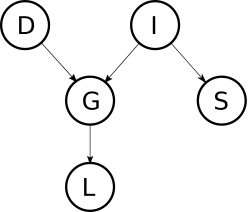"></img>

Las variables representadas son:

* **Nota examen (G)**: g0 (sobresaliente), g1 (notable), g2 (aprobado).
* **Dificultad examen (D)**: d0 (fácil) y d1 (difícil).
* **Inteligencia (I)**: i0 (normal), i1 (alta).
* **Nota Selectividad (S)**: s0 (baja), s1 (alta).
* **Carta de recomendación (L)**: l0 (regular), l1 (buena).

La distribución conjunta es entonces:

$$P(I,D, G,L,S) = P(I)P(D)P(G|I,D)P(L|G)P(S|I).$$

In [3]:
# Dimensión -> 0  1  2  3  4
# Variable  -> I  D  G  L  S

PI = np.array([0.7, 0.3]).reshape((2, 1, 1, 1, 1))
PD = np.array([0.6, 0.4]).reshape((1, 2, 1, 1, 1))
PG_ID = np.array([0.3, 0.4, 0.3, 0.05, 0.25, 0.7, 0.9, 0.08, 0.02, 0.5, 0.3, 0.2]).reshape((2, 2, 3, 1, 1))
PL_G = np.array([0.1, 0.9, 0.4, 0.6, 0.99, 0.01]).reshape((1, 1, 3, 2, 1))
PS_I = np.array([0.95, 0.05, 0.2, 0.8]).reshape((2, 1, 1, 1, 2))

# Distribución conjunta
PIDGLS = PI * PD * PG_ID * PL_G* PS_I

# Red bayesiana
network = BayesianNetwork([PI, PD, PG_ID, PL_G, PS_I])

Establecemos una serie de casos de prueba.

In [4]:
# ¿Cuál es la distribución P(I)?
factor, max_size = network.VE([0])
assert(np.allclose(np.array([[[[[0.7]]]], [[[[0.3]]]]]), factor))
assert(max_size == 12)

# Si sabemos que la nota del examen es aprobado, ¿cuál es la distribución de la inteligencia? 
# P(I|G=g2)
factor, max_size = network.VE([0], [2], [2])
assert(np.allclose(np.array([[[[[0.92105263]]]], [[[[0.07894737]]]]]), factor))
assert(max_size == 4)

# Y si además el examen es difícil?
# P(I|G=g2,D=d1)
factor, max_size = network.VE([0], [1,2], [1,2])
assert(np.allclose(np.array([[[[[0.89090909]]]], [[[[0.10909091]]]]]), factor))
assert(max_size == 4)

print("Todos los casos de prueba son correctos.")

Todos los casos de prueba son correctos.


In [5]:
# Calcula la distribución P(D)
factor, max_size = network.VE([1])
assert(np.allclose(np.array([[[[[0.6]]], [[[0.4]]]]]), factor))
assert(max_size == 24)

# Prob examen si nota es aprobado: P(D|G=g2)
factor, max_size = network.VE([1], [2], [2])
assert(np.allclose(np.array([[[[[0.37070938]]], [[[0.62929062]]]]]), factor))
assert(max_size == 8)

# Probabilidad de examen difícil D=d1 dado que G=g2 y S=s1
factor, max_size = network.VE([1], [2,4], [2,1])
assert(np.allclose(np.array([[[[[0.24044002]]], [[[0.75955998]]]]]), factor))
assert(max_size == 4)

print("Todos los casos de prueba son correctos.")

Todos los casos de prueba son correctos.


Finalmente estudiamos cómo influyen unas variables sobre otras, dependiendo de la evidencia que tengamos. En concreto, nos preguntamos si la nota de selectividad (S) influye en la dificultad del examen (D), dependiendo de si conocemos o no su nota (G).

In [6]:
# P(D)
pd, _ = network.VE([1])
print("Distribución de D:\n", pd)

# P(D|S=1), no conocemos G
pd_s1, _ = network.VE([1], [4], [1])
print("\nDistribución de D|S=1:\n", pd_s1)
if np.allclose(pd_s1, pd):
    print("--> No cambia")
else:
    print("--> Cambia")

# P(D|G=2)
pd_g2, _ = network.VE([1], [2], [2])
print("\nDistribución de D|G=2:\n", pd_g2)
if np.allclose(pd_g2, pd):
    print("--> No cambia")
else:
    print("--> Cambia")

# P(D|G=2,S=1), conocemos G
pd_g2s1, _ = network.VE([1], [2, 4], [2, 1])
print("\nDistribución de D|G=2,S=1:\n", pd_g2s1)
if np.allclose(pd_g2s1, pd):
    print("--> No cambia")
else:
    print("--> Cambia")

Distribución de D:
 [[[[[0.6]]]


  [[[0.4]]]]]

Distribución de D|S=1:
 [[[[[0.6]]]


  [[[0.4]]]]]
--> No cambia

Distribución de D|G=2:
 [[[[[0.37070938]]]


  [[[0.62929062]]]]]
--> Cambia

Distribución de D|G=2,S=1:
 [[[[[0.24044002]]]


  [[[0.75955998]]]]]
--> Cambia
